In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

caminho_base_continente = Path.cwd().parent / 'data' / 'processed' / 'base_continente.csv'
base_continente = pd.read_csv(caminho_base_continente, sep=';')

caminho_base_pais = Path.cwd().parent / 'data' / 'processed' / 'base_pais.csv'
base_pais = pd.read_csv(caminho_base_pais, sep=';')

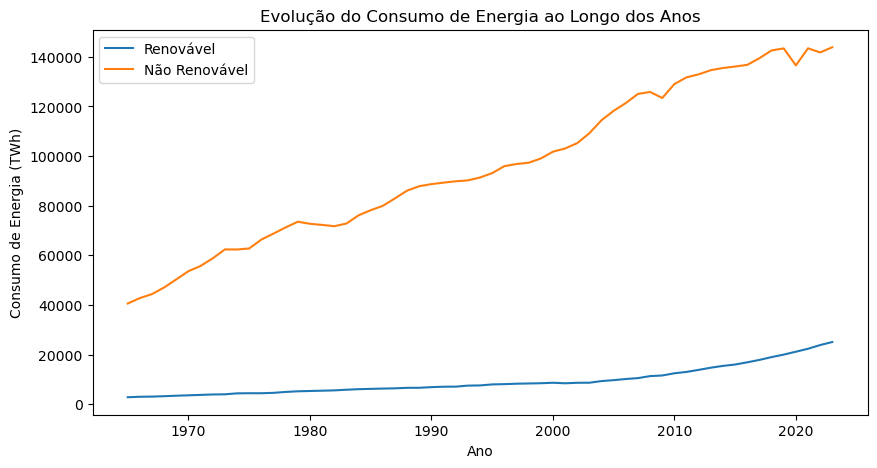

In [11]:
#Como o consumo total de energia (renovável e não renovável) mudou ao longo dos anos?

base_continente.groupby('ano')[['energia_renovavel', 'energia_nao_renovavel']].sum().plot(figsize=(10,5))
plt.title('Evolução do Consumo de Energia ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Consumo de Energia (TWh)')
plt.legend(['Renovável', 'Não Renovável'])
plt.show()

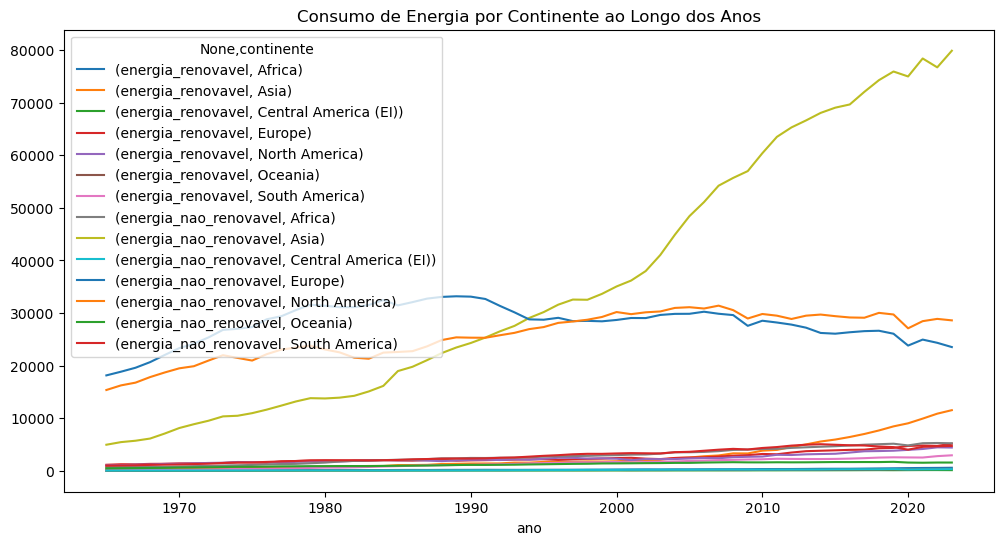

In [13]:
#Como os diferentes continentes evoluíram no consumo de energia?

base_continente.groupby(['ano', 'continente'])[['energia_renovavel', 'energia_nao_renovavel']].sum().unstack().plot(figsize=(12,6))
plt.title('Consumo de Energia por Continente ao Longo dos Anos')
plt.show()


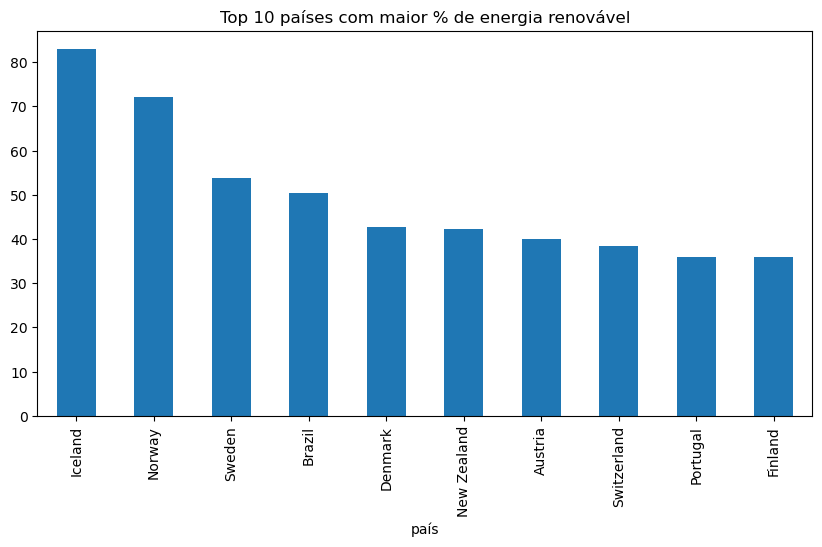

In [14]:
#Quais países mais aumentaram a participação de energia renovável nos últimos anos?

base_pais['perc_renovavel'] = base_pais['energia_renovavel'] / (base_pais['energia_renovavel'] + base_pais['energia_nao_renovavel']) * 100
top_paises = base_pais.groupby('país')['perc_renovavel'].last().sort_values(ascending=False).head(10)
top_paises.plot(kind='bar', figsize=(10,5), title="Top 10 países com maior % de energia renovável")
plt.show()


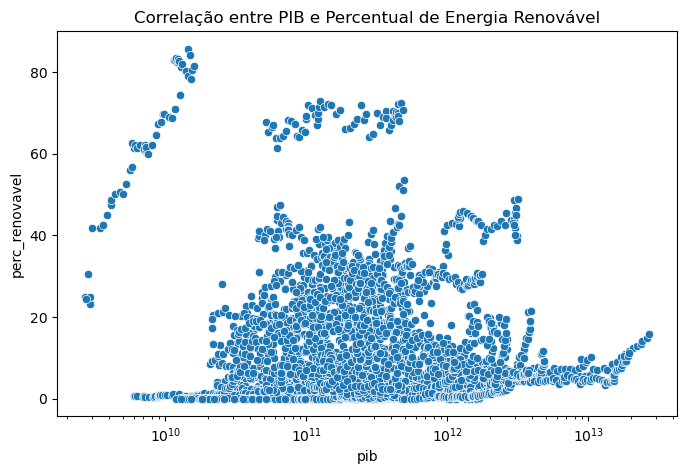

In [16]:
# Países mais ricos investem mais em energia renovável?

plt.figure(figsize=(8,5))
sns.scatterplot(data=base_pais, x='pib', y='perc_renovavel')
plt.xscale('log')  # PIB tem grande variação, usar escala logarítmica
plt.title('Correlação entre PIB e Percentual de Energia Renovável')
plt.show()


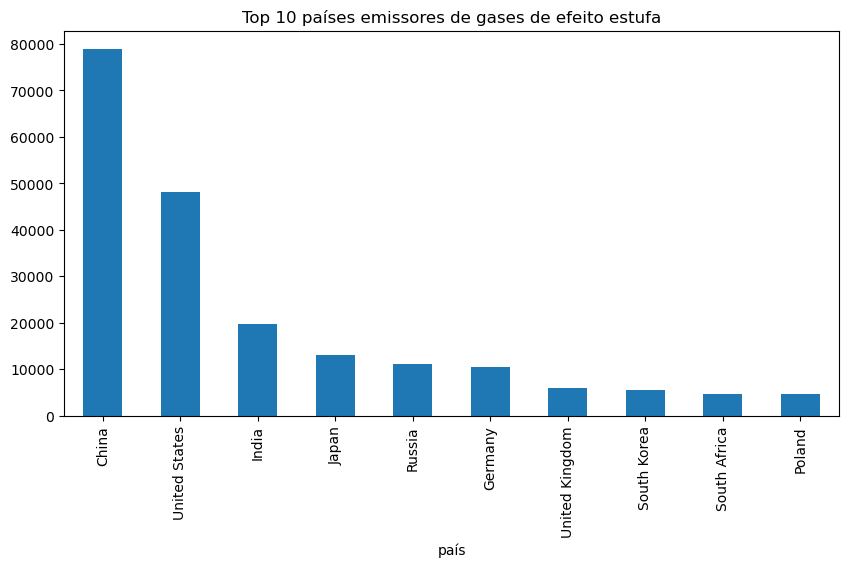

In [17]:
#Quais países têm as maiores emissões de CO₂ e como isso se relaciona com o consumo de energia?

top_emissores = base_pais.groupby('país')['emissões_gases_efeito_estufa'].sum().sort_values(ascending=False).head(10)
top_emissores.plot(kind='bar', figsize=(10,5), title="Top 10 países emissores de gases de efeito estufa")
plt.show()

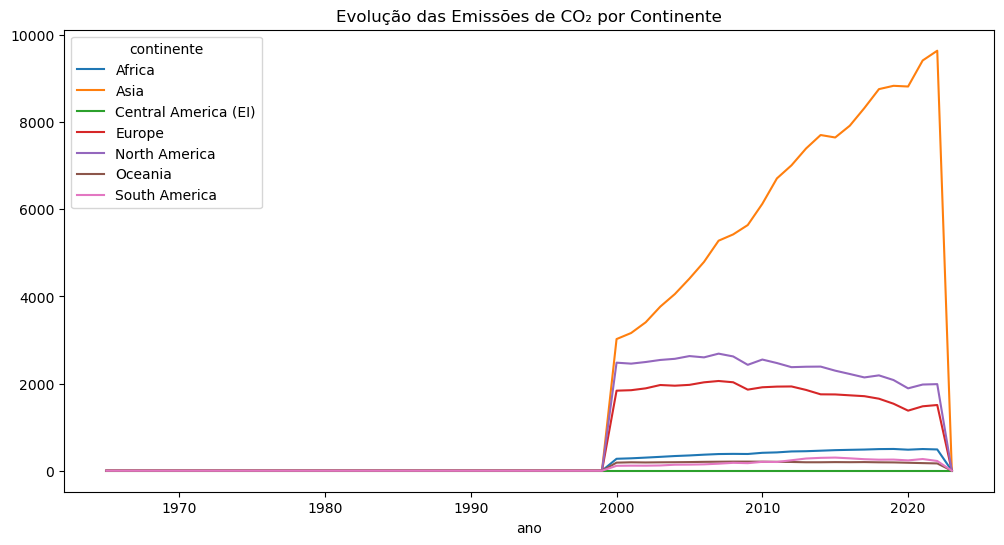

In [18]:
#Qual continente mais reduziu suas emissões ao longo do tempo?

base_continente.groupby(['ano', 'continente'])['emissões_gases_efeito_estufa'].sum().unstack().plot(figsize=(12,6))
plt.title('Evolução das Emissões de CO₂ por Continente')
plt.show()


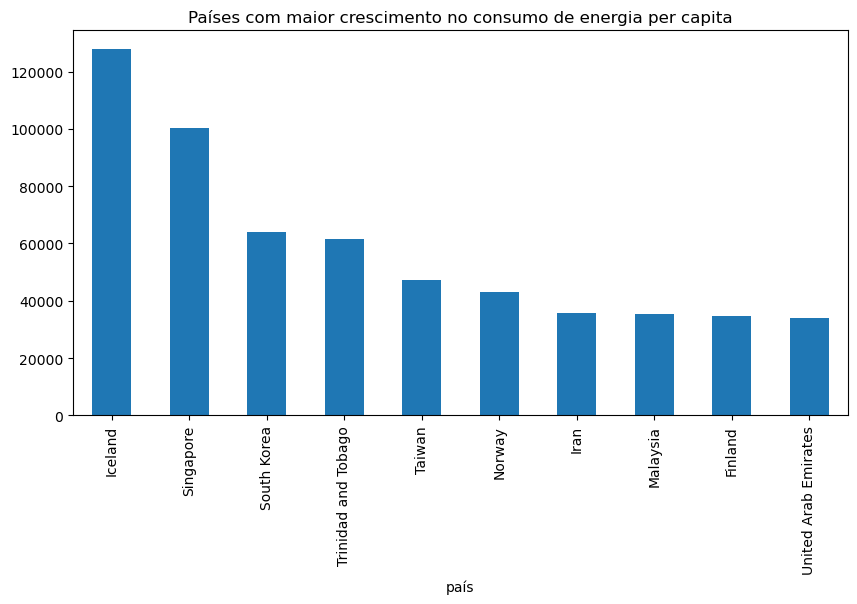

In [19]:
#Países com maior crescimento no consumo de energia:
variacao = base_pais.groupby('país')['energia_per_capita'].last() - base_pais.groupby('país')['energia_per_capita'].first()
variacao.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10,5), title="Países com maior crescimento no consumo de energia per capita")
plt.show()
